In [37]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

-------

<h1 align="center"> Data Exploration </h1><br>
This notebook explores the provided crop and livestock predicts from FAOSTAT. Scatterplots were generated comparing disease mortality rates per 100,000 and food item consumption in kg/capita/year. This analysis was extended for cancer, diabetes, and cardiovascular disease and over 100 predictors were examined. The top positively and negatively correlated predictors are printed below.

***

In [13]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
import math
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score as val_score
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split as sk_split
import statsmodels.api as sm
import missingno as msno

%matplotlib inline

We began our data exploration by identifying all the crop and livestock predictors that could have an influence on the morality rate. The list of all predictors are below. They span a variety of food cateogries and are foods found in almost all parts of the world with few regional specialities. This gives us the ability to directly compare countries that are not geographically adjacent. 

In [426]:
#read in crops
allcrops_2000 = pd.read_csv('datasets/allcrops_2000.csv')
# names of all the crops
crop_names = allcrops_2000['Item'].unique()

# remove nan
crop_names = crop_names[:-1]
# list to put our separated crop dataframes
all_crop_dfs = []

# find each crop-separated df and put it in the list of dataframes
for crop in crop_names:
    crop_df = allcrops_2000[(allcrops_2000['Item'] == crop)]
    all_crop_dfs.append(crop_df)

print "List of all crop predictors: \n", crop_names

List of all crop predictors: 
['Apples and products' 'Bananas' 'Barley and products' 'Beer'
 'Beverages, Alcoholic' 'Cereals, Other' 'Citrus, Other'
 'Cocoa Beans and products' 'Coconuts - Incl Copra' 'Coffee and products'
 'Cottonseed Oil' 'Dates' 'Fruits, Other' 'Grapes and products (excl wine)'
 'Groundnut Oil' 'Infant food' 'Maize and products' 'Millet and products'
 'Nuts and products' 'Oilcrops Oil, Other' 'Olive Oil'
 'Olives (including preserved)' 'Oranges, Mandarines' 'Palm Oil' 'Pepper'
 'Pineapples and products' 'Potatoes and products'
 'Pulses, Other and products' 'Rape and Mustard Oil'
 'Rice (Milled Equivalent)' 'Rice (Paddy Equivalent)'
 'Roots & Tuber Dry Equiv' 'Sesame seed' 'Sesameseed Oil' 'Soyabean Oil'
 'Spices, Other' 'Sugar (Raw Equivalent)' 'Sugar, Raw Equivalent'
 'Sugar, Refined Equiv' 'Sunflowerseed Oil' 'Sweeteners, Other'
 'Tea (including mate)' 'Tomatoes and products' 'Vegetables, Other'
 'Wheat and products' 'Wine' 'Beans' 'Beverages, Fermented'
 'Cassava

In [427]:
# Do the same as above, but for livestock
livestock_2000 = pd.read_csv('datasets/livestock_2000.csv')
# list of livestock names
livestock_names_all = livestock_2000['Item'].unique()
livestock_names_all = livestock_names_all[1:-1]
livestock_names = []
for name in livestock_names_all:
    if name != 'Grand Total':
        livestock_names.append(name)

# list to put our separated dataframes
livestock_dfs = []

# separate dataframe based on itemname
for crop in livestock_names:
    crop_df = livestock_2000[(livestock_2000['Item'] == crop)]
    livestock_dfs.append(crop_df)

print "List of all livestock predictors: \n", livestock_names

List of all livestock predictors: 
['Butter, Ghee', 'Cheese', 'Cream', 'Eggs', 'Fats, Animals, Raw', 'Freshwater Fish', 'Honey', 'Meat, Other', 'Milk - Excluding Butter', 'Milk, Whole', 'Mutton & Goat Meat', 'Offals, Edible', 'Poultry Meat', 'Aquatic Animals, Others', 'Aquatic Plants', 'Cephalopods', 'Crustaceans', 'Demersal Fish', 'Fish, Body Oil', 'Fish, Liver Oil', 'Marine Fish, Other', 'Molluscs, Other', 'Pelagic Fish', 'Pigmeat', 'Whey', 'Meat, Aquatic Mammals']


The next step is to read in disease data and separate 2000 data from 2012 data for analysis. Since 2000 food data is more plentiful, discussed in further detail below, we chose to focus on that year for more accurate model results due to less data extrapolation.

In [428]:
# read in disease rates
column_headers = ["Country", "Year", "Mortality", "Mortality 2", "Mortality 3"]
diabetes = pd.read_csv('datasets/diabetes.csv', names = column_headers)
cardio = pd.read_csv('datasets/cardiovascular.csv', names = column_headers)
cancer= pd.read_csv('datasets/Cancer.csv', names = column_headers)
all_foods = all_crop_dfs

In [429]:
cardio.iloc[3:, 0:3].head(n=5)
#cardio.columns = ['Country', 'Year', 'Mortality']

,Country,Year,Mortality
3,Afghanistan,2012,511.5
4,Afghanistan,2000,542.3
5,Albania,2012,436.2
6,Albania,2000,560.5
7,Algeria,2012,396.6


# Missing Data - 2012

In [20]:
#read in crops
crop_2012 = pd.read_csv('crop_2012.csv')
# names of all the crops
crop_names = crop_2012['Item'].unique()

# remove nan
# list to put our separated crop dataframes
all_crop_dfs = []

# find each crop-separated df and put it in the list of dataframes
for crop in crop_names:
    crop_df = crop_2012[(crop_2012['Item'] == crop)]
    all_crop_dfs.append(crop_df)

In [430]:
# separate out 2012 and 2000 data
cardio_2012 = cardio[(cardio["Year"] == "2012")] 
cardio_2000 = cardio[(cardio["Year"] == "2000")] 
diabetes_2012 = diabetes[(diabetes['Year'] == '2012')] 
diabetes_2000 = diabetes[(diabetes['Year'] == '2000')] 
cancer_2012 = cancer[(cancer['Year'] == ' 2012')] 
cancer_2000 = cancer[(cancer['Year'] == ' 2000')] 

In [21]:
# Do the same as above, but for livestock
livestock_2012 = pd.read_csv('livestock_2012.csv')
# list of livestock names
livestock_names = livestock_2012['Item'].unique()

# list to put our separated dataframes
livestock_dfs = []

# separate dataframe based on itemname
for crop in livestock_names:
    crop_df = livestock_2012[(livestock_2012['Item'] == crop)]
    livestock_dfs.append(crop_df)

In [16]:
crop_missing = pd.DataFrame(columns = crop_names)
country_list = crop_2012['Country'].unique()
end = crop_missing.shape[0]
for country in country_list:
    test = crop_2012[crop_2012['Country'] == str(country)]
    newrow = []
    for food in crop_names:
        appended = False
        for index, row in test.iterrows():
            if row["Item"] == str(food):
                newrow.append(row["Value"])
                appended = True
        if not appended:
            newrow.append(np.NaN)
    crop_missing.loc[end+1] = newrow
    end += 1

In [17]:
livestock_missing = pd.DataFrame(columns = livestock_names)
country_list = livestock_2012['Country'].unique()
end = livestock_missing.shape[0]
for country in country_list:
    test = livestock_2012[livestock_2012['Country'] == str(country)]
    newrow = []
    for food in livestock_names:
        appended = False
        for index, row in test.iterrows():
            if row["Item"] == str(food):
                newrow.append(row["Value"])
                appended = True
        if not appended:
            newrow.append(np.NaN)
    livestock_missing.loc[end+1] = newrow
    end += 1

In [14]:
food_missing = pd.concat([livestock_missing, crop_missing], axis = 1)

We were provided food and disease data for both 2000 and 2012. However, after preliminary data analysis, we discovered that the 2012 crop and livestock data was largely incomplete. While it had the same number of food predictors, there were only 44 countries reported. In the visual below, the top 45 most incomplete food predictors are displayed horizontally at the top. On the left hand vertical axis, it lists each country (too many to name so they are not printed). However, we see that there are 44 total rows, corresponding to 44 countries with data even though the world currently has 175 countries. 

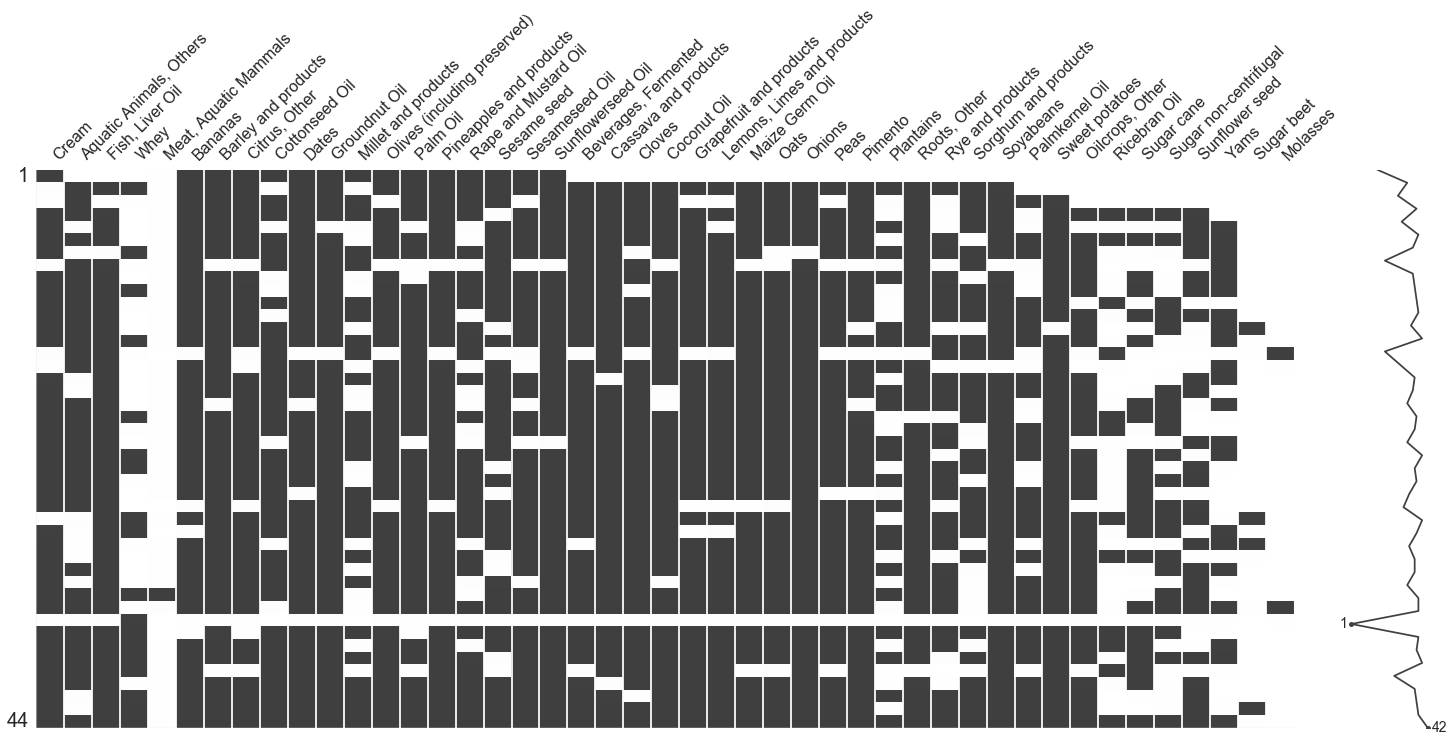

In [15]:
filtered_data = msno.nullity_filter(food_missing, filter='bottom', n=45, p=0.999) 
msno.matrix(filtered_data)

# Missing Data - 2000

In [22]:
#read in crops
crop_2000 = pd.read_csv('datasets/allcrops_2000.csv')
# names of all the crops
crop_names = crop_2000['Item'].unique()

# remove nan
# list to put our separated crop dataframes
all_crop_dfs = []

# find each crop-separated df and put it in the list of dataframes
for crop in crop_names:
    crop_df = crop_2000[(crop_2000['Item'] == crop)]
    all_crop_dfs.append(crop_df)


In [24]:
# Do the same as above, but for livestock
livestock_2000 = pd.read_csv('datasets/livestock_2000.csv')
# list of livestock names
livestock_names = livestock_2000['Item'].unique()

# list to put our separated dataframes
livestock_dfs = []

# separate dataframe based on itemname
for crop in livestock_names:
    crop_df = livestock_2000[(livestock_2000['Item'] == crop)]
    livestock_dfs.append(crop_df)

In [25]:
crop_missing = pd.DataFrame(columns = crop_names)
country_list = crop_2000['Country'].unique()
end = crop_missing.shape[0]
for country in country_list:
    test = crop_2000[crop_2000['Country'] == str(country)]
    newrow = []
    for food in crop_names:
        appended = False
        for index, row in test.iterrows():
            if row["Item"] == str(food):
                newrow.append(row["Value"])
                appended = True
        if not appended:
            newrow.append(np.NaN)
    crop_missing.loc[end+1] = newrow
    end += 1

In [26]:
livestock_missing = pd.DataFrame(columns = livestock_names)
country_list = livestock_2000['Country'].unique()
end = livestock_missing.shape[0]
for country in country_list:
    test = livestock_2000[livestock_2000['Country'] == str(country)]
    newrow = []
    for food in livestock_names:
        appended = False
        for index, row in test.iterrows():
            if row["Item"] == str(food):
                newrow.append(row["Value"])
                appended = True
        if not appended:
            newrow.append(np.NaN)
    livestock_missing.loc[end+1] = newrow
    end += 1

In contrast, the food and livestock data for 2000 was much more complete. We seem a similiar plentify array of food predictor values on the horizontal axis. The main benefit is from the vertical axis: there is now data for 175 individual countries instead of just 44. This gives us more data points to build an accurate model. Since it is hard to extrapolate values for all the missing countries in 2012, instead of using both 2000 and 2012 data, we decided to just pursue with 2000. To have separate testing and training sets, we used sksplit to separate the 2000 data and cross validation to reduce variability. This enabled us to successfully test our models without having to rely on 2012 data. 

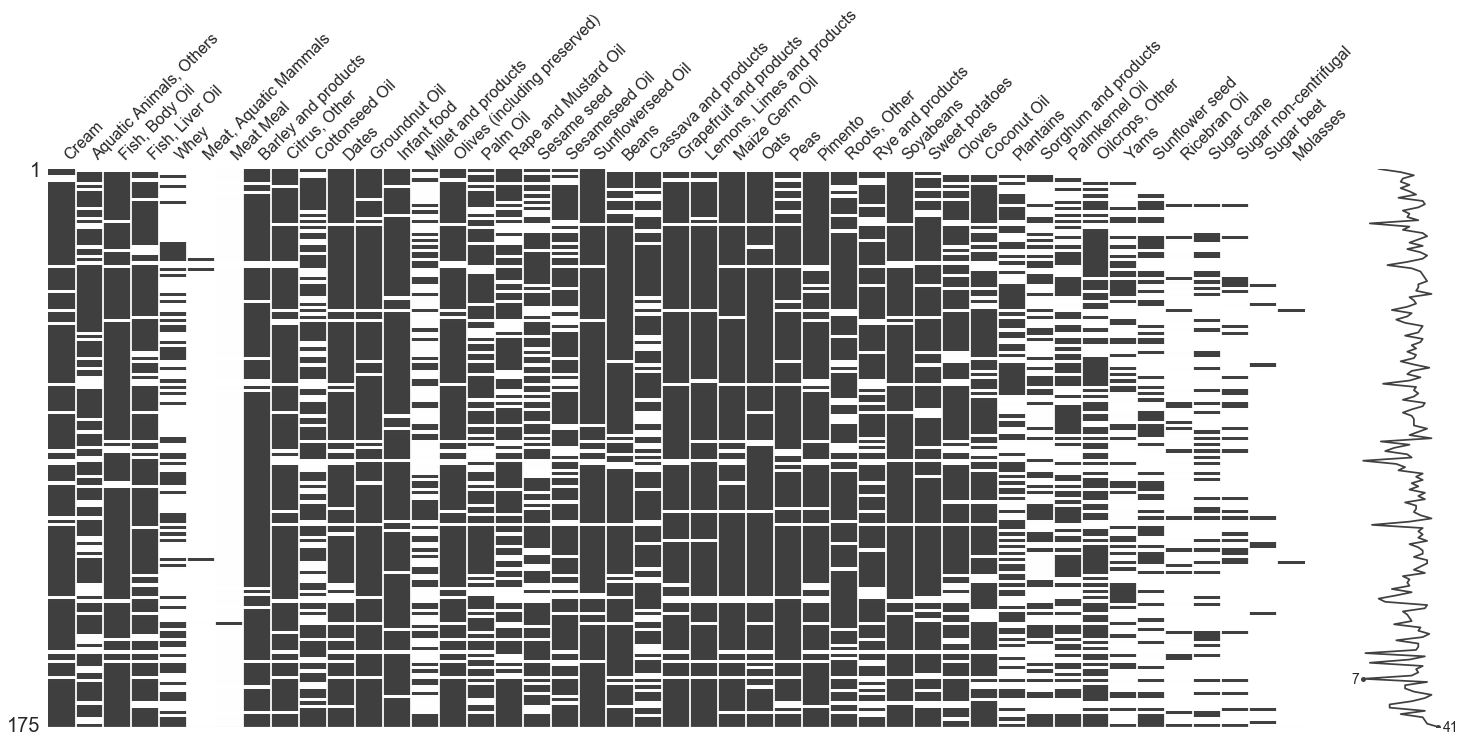

In [28]:
food_missing = pd.concat([livestock_missing, crop_missing], axis = 1)
filtered_data = msno.nullity_filter(food_missing, filter='bottom', n=45, p=0.999) 
msno.matrix(filtered_data)

In [31]:
crop_2000 = pd.read_csv('datasets/allcrops_2000.csv')
crop_names = crop_2000['Country'].unique()
len_2000 = len(crop_names)
print "Number of 2000 food crops: ", len(crop_names)
crop_names = crop_2012['Country'].unique()
len_2012 = len(crop_names)
print "Number of 2000 food crops: ", len(crop_names)

Number of 2000 food crops:  175
Number of 2000 food crops:  44


The bar graph below emphasizes the size of the disparity in aggregate data. The number of countries present in 2000 data is nearly 4 times the size of 2012 data. This is just another visualization that confirms our decision to puruse with 2000 data. 

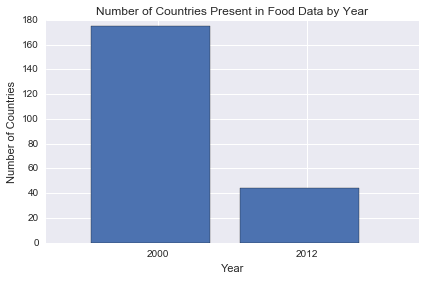

In [32]:
n_groups = 2

means_women = (len_2000, len_2012)

fig, ax = plt.subplots()

index = np.arange(n_groups)

bar_width = 0.3
error_config = {'ecolor': '0.3'}

rects2 = plt.bar(index + bar_width, means_women)

plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.title('Number of Countries Present in Food Data by Year')
plt.xticks(index + 2.5*bar_width, ('2000', '2012'))

plt.tight_layout()
plt.show()

Since we are purusing with 2000 data, the next step was to separate disease data by year so we can focus on 2000 for further analysis.

### Separated 2012 disease data

In [431]:
cardio_2012.head(n=5)

,Country,Year,Mortality,Mortality 2,Mortality 3
3,Afghanistan,2012,511.5,520.9,498.0
5,Albania,2012,436.2,417.6,447.4
7,Algeria,2012,396.6,359.9,434.6
9,Angola,2012,374.6,369.8,376.4
11,Argentina,2012,191.7,148.4,247.8


### Separated 2000 disease data

In [432]:
cardio_2000.head(n=5)

,Country,Year,Mortality,Mortality 2,Mortality 3
4,Afghanistan,2000,542.3,554.1,523.1
6,Albania,2000,560.5,494.7,638.6
8,Algeria,2000,434.7,401.2,472.2
10,Angola,2000,383.4,385.2,375.2
12,Argentina,2000,226.6,169.1,302.8


# R Squared Predictor Analysis

We generated a food data function that concatenates a separate list of food amounts and disease morality rates for each country. It has the potential to plot the information on a scatterplot with each country as a separate datapoint and uses linear regression to obtain an R squared value of the correlation strength. For this chapter, these R squared values are first used to find suggestive food predictors. Then, scatterplots are generated to understand the nature of the correlation.

In [433]:
# plot for cardio
def food_disease_plot(disease_name, disease, food_df, ax):
    score = 1
    morts = []
    food_amts = []
    
    # for each country
    for country in food_df['Country'].values:
        # make sure it's in the disease df
        if not disease[(disease['Country'] == country)].empty:
            # find the disease data for that country
            country_data = disease[(disease['Country'] == country)]
            # find mortality rate
            mort = country_data.iloc[1,2]
            # append to mortality list
            morts.append(float(mort))
            # find amount of that particular food consumed in that country
            food_amt = food_df[(food_df['Country'] == country)]["Value"]
            # append to food_amounts
            food_amts.append(float(food_amt))
    
    # scatter the amounts against mortality rates
    ax.scatter(food_amts, morts)
    
    # reshape for LinReg to get R^2
    X = np.array(food_amts).reshape(-1, 1)
    y = np.array(morts)
    
    if (len(food_df['Item'].values) > 0) and (X.shape[0] > 0):
        # linreg
        regr = LinReg()
        # fit, score linreg
        regr.fit(X, y)
        score = regr.score(X,y)
        ax.set_title("R^2 = " + str(score))
    
    ax.set_xlabel((food_df['Item'].values[0]) + str(' (kg/capita/yr)'))
    ax.set_ylabel(str(disease_name) + ' Disease Mortality Rate')
    
    return ax, score

In [441]:
# cardio and crops r2
cardio_crop_r2 = {}

# go through and plot each one
for df, ax in zip(all_crop_dfs, axes):
    ax, r2 = food_disease_plot("Cardio", cardio, df, ax)
    crop_name = df['Item'].values[0]
    cardio_crop_r2[crop_name] = r2
    
# cardio and livestock r2
cardio_livestock_r2 = {}

# go through and plot each one
for df, ax in zip(livestock_dfs, axes):
    ax, r2 = food_disease_plot("Cardio", cardio, df, ax)
    crop_name = df['Item'].values[0]
    cardio_livestock_r2[crop_name] = r2

In [442]:
# diabetes and crops r2
diabetes_crop_r2 = {}

# go through and plot each one
for df, ax in zip(all_crop_dfs, axes):
    ax, r2 = food_disease_plot("Diabetes", diabetes, df, ax)
    crop_name = df['Item'].values[0]
    diabetes_crop_r2[crop_name] = r2
    
# diabetes and livestock r2
diabetes_livestock_r2 = {}

# go through and plot each one
for df, ax in zip(livestock_dfs, axes):
    ax, r2 = food_disease_plot("Diabetes", diabetes, df, ax)
    crop_name = df['Item'].values[0]
    diabetes_livestock_r2[crop_name] = r2

In [443]:
# cancer and crop r2
cancer_crop_r2 = {}

# go through and plot each one
for df, ax in zip(all_crop_dfs, axes):
    ax, r2 = food_disease_plot("Cancer", cancer, df, ax)
    crop_name = df['Item'].values[0]
    cancer_crop_r2[crop_name] = r2
    
# cancer and livestock r2
cancer_livestock_r2 = {}

# go through and plot each one
for df, ax in zip(livestock_dfs, axes):
    ax, r2 = food_disease_plot("Cancer", cancer, df, ax)
    crop_name = df['Item'].values[0]
    cancer_livestock_r2[crop_name] = r2

After generating statistics across all food-disease pairs, crop and livestock predictors were combined together into one dictionary for more thorough food predictor analysis so their impact can be compared directly. The predictors for each disease are then sorted by impact level to identify the most informative predictors.

In [444]:
# dictionary of all dataframes, crop and livestock
all_dfs = {}
for df in all_crop_dfs:
    crop_name = df['Item'].values[0]
    all_dfs[crop_name] = df

for df in livestock_dfs:
    crop_name = df['Item'].values[0]
    all_dfs[crop_name] = df

In [445]:
for k, v in cancer_livestock_r2.items():
    cancer_crop_r2[k] = v
for k, v in diabetes_livestock_r2.items():
    diabetes_crop_r2[k] = v
for k, v in cardio_livestock_r2.items():
    cardio_crop_r2[k] = v

In [447]:
cancer_r2_sort = sorted(cancer_crop_r2.items(), key= lambda x: -x[1])
diabetes_r2_sort = sorted(diabetes_crop_r2.items(), key= lambda x: -x[1])
cardio_r2_sort = sorted(cardio_crop_r2.items(), key= lambda x: -x[1])

In [448]:
def predictors_plot(disease, disease_sort):
    item_array = []
    r2_array = []
    for item, r2 in disease_sort:
        item_array.append(item)
        r2_array.append(r2)
    print "Top 15 Most important", disease, "predictors and their corresponding r squared values: \n", disease_sort[0:15]
    plt.barh(range(len(r2_array[0:15])),r2_array[0:15],align='center')
    plt.yticks(range(len(item_array[0:15])),item_array[0:15])
    plt.xlabel('R Squared Value')
    plt.ylabel('Predictor Name')
    plt.title('Relative importance of Each Food in Predicting ' + str(disease) + ' Morality Rates')
    plt.show()
    top15 = item_array[0:15]
    return top15

Top 15 Most important Cancer predictors and their corresponding r squared values: 
[('Potatoes and products', 0.18146714554204713), ('Fats, Animals, Raw', 0.13836803444212109), ('Apples and products', 0.12685735601591541), ('Palm Oil', 0.11992349320211892), ('Offals, Edible', 0.11226383680455887), ('Beverages, Alcoholic', 0.11173519114238595), ('Milk - Excluding Butter', 0.11142412953358283), ('Pigmeat', 0.11016505762966677), ('Cream', 0.10011991409978982), ('Pulses, Other and products', 0.099056591094852209), ('Cheese', 0.098148069716460173), ('Eggs', 0.094839037277499871), ('Beer', 0.090596219495131525), ('Wine', 0.074326137388987967), ('Cocoa Beans and products', 0.071497244953764749)]


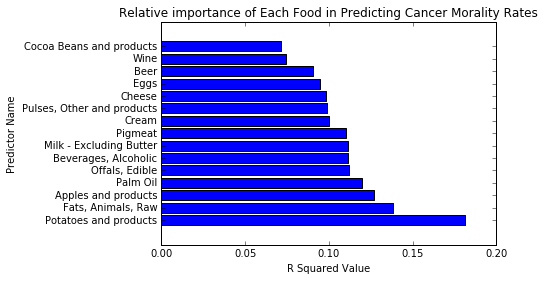

In [449]:
cancer_top15 = predictors_plot("Cancer", cancer_r2_sort)

Top 15 Most important Diabetes predictors and their corresponding r squared values: 
[('Potatoes and products', 0.2329604980119504), ('Milk - Excluding Butter', 0.19969407923376481), ('Pigmeat', 0.19253767532389077), ('Apples and products', 0.15652111902923338), ('Cheese', 0.14383934926938957), ('Wine', 0.12702378306686479), ('Milk, Whole', 0.11984650853887568), ('Eggs', 0.1146558328529067), ('Cream', 0.10908691840397299), ('Coffee and products', 0.10560223330637797), ('Pulses, Other and products', 0.099760132258112977), ('Rye and products', 0.098480879238826757), ('Rape and Mustard Oil', 0.098442076113427812), ('Butter, Ghee', 0.095543733389780616), ('Beer', 0.094928757240494432)]


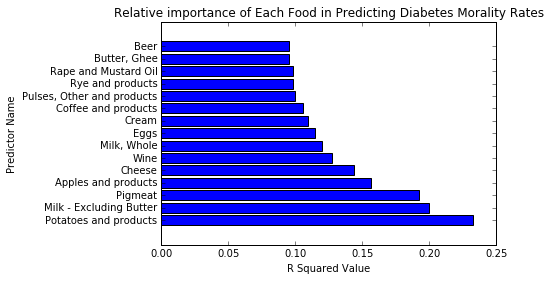

In [450]:
diabetes_top15 = predictors_plot("Diabetes", diabetes_r2_sort)

Top 15 Most important Cardio predictors and their corresponding r squared values: 
[('Wheat and products', 0.1769115917312033), ('Cottonseed Oil', 0.16233585584342736), ('Coffee and products', 0.150944981458219), ('Oranges, Mandarines', 0.14045290297240975), ('Molluscs, Other', 0.1148933629111597), ('Cheese', 0.11437142383705025), ('Beer', 0.11153274849099704), ('Poultry Meat', 0.1092773280445376), ('Sugar, Raw Equivalent', 0.1006500283481213), ('Crustaceans', 0.095665062661258848), ('Pigmeat', 0.088258357775067631), ('Soyabean Oil', 0.088158071312481545), ('Ricebran Oil', 0.085285860529225266), ('Cephalopods', 0.083990040870099314), ('Rape and Mustard Oil', 0.083554953546264077)]


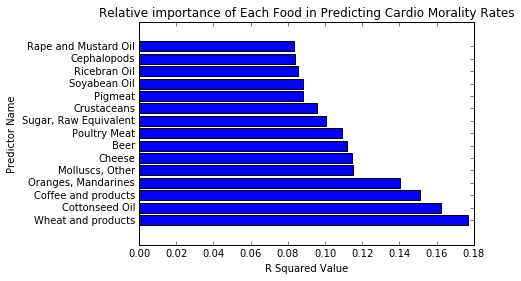

In [451]:
cardio_top15 = predictors_plot("Cardio", cardio_r2_sort)

The above bar graphs display the most predictors with the highest R squared values in comparing food consumption quantity to disease mortality rates. It indicates a preliminary breakdown of critical foods that have a linear relationship. These foods suggest the presence of a linear relationship but it is worth noting that it does not speak to the magnitude of the impact, which is rather conveyed by the size of the coefficient, explored in the Data Analysis chapter.

For cancer and diabetes, the most predictive food item were potatoes and products and it was wheat and products for cardiovascular disease. Based on these values alone, it appears that carbohydrate heavy foods have a relationship with disease incidence rates. However R squared values does not tell you about the nature of this relationship: whether additional consumption increases or decreases the risk of contracting a disease. We observe that apples and products also rank highly as a predictor for cancer and diabetes. Intuitively, carbohydrate loaded foods should increase the risk the non-communicable disease while fruits and vegetables should decrease the risk. However, we cannot verify these theories from a single value alone. To further study these trends, we decided to generate scatterplots of the data to understand our observations from a granular, country-level prespective. 

# Scatterplot Visualizations

In [453]:
def top_15(disease_top15, disease_name, disease):
    # aggregate dataframes of top 15 combined crop and livestock predictors
    top_15 = []
    for each in disease_top15:
        top_15.append(all_dfs[each])

    # plot scatterplots of top 15 predictors
    fig, ax = plt.subplots(3, 5, figsize=(25, 15))
    axes = [e for l in ax for e in l]

    top_15_r2 = {}

    for df, ax in zip(top_15, axes):
        ax, r2 = food_disease_plot(disease_name, disease, df, ax)
        livestock_name = df['Item'].values[0]
        top_15_r2[livestock_name] = r2

    plt.tight_layout()
    plt.show()

### Scatterplot of food predictors and cancer mortality rates

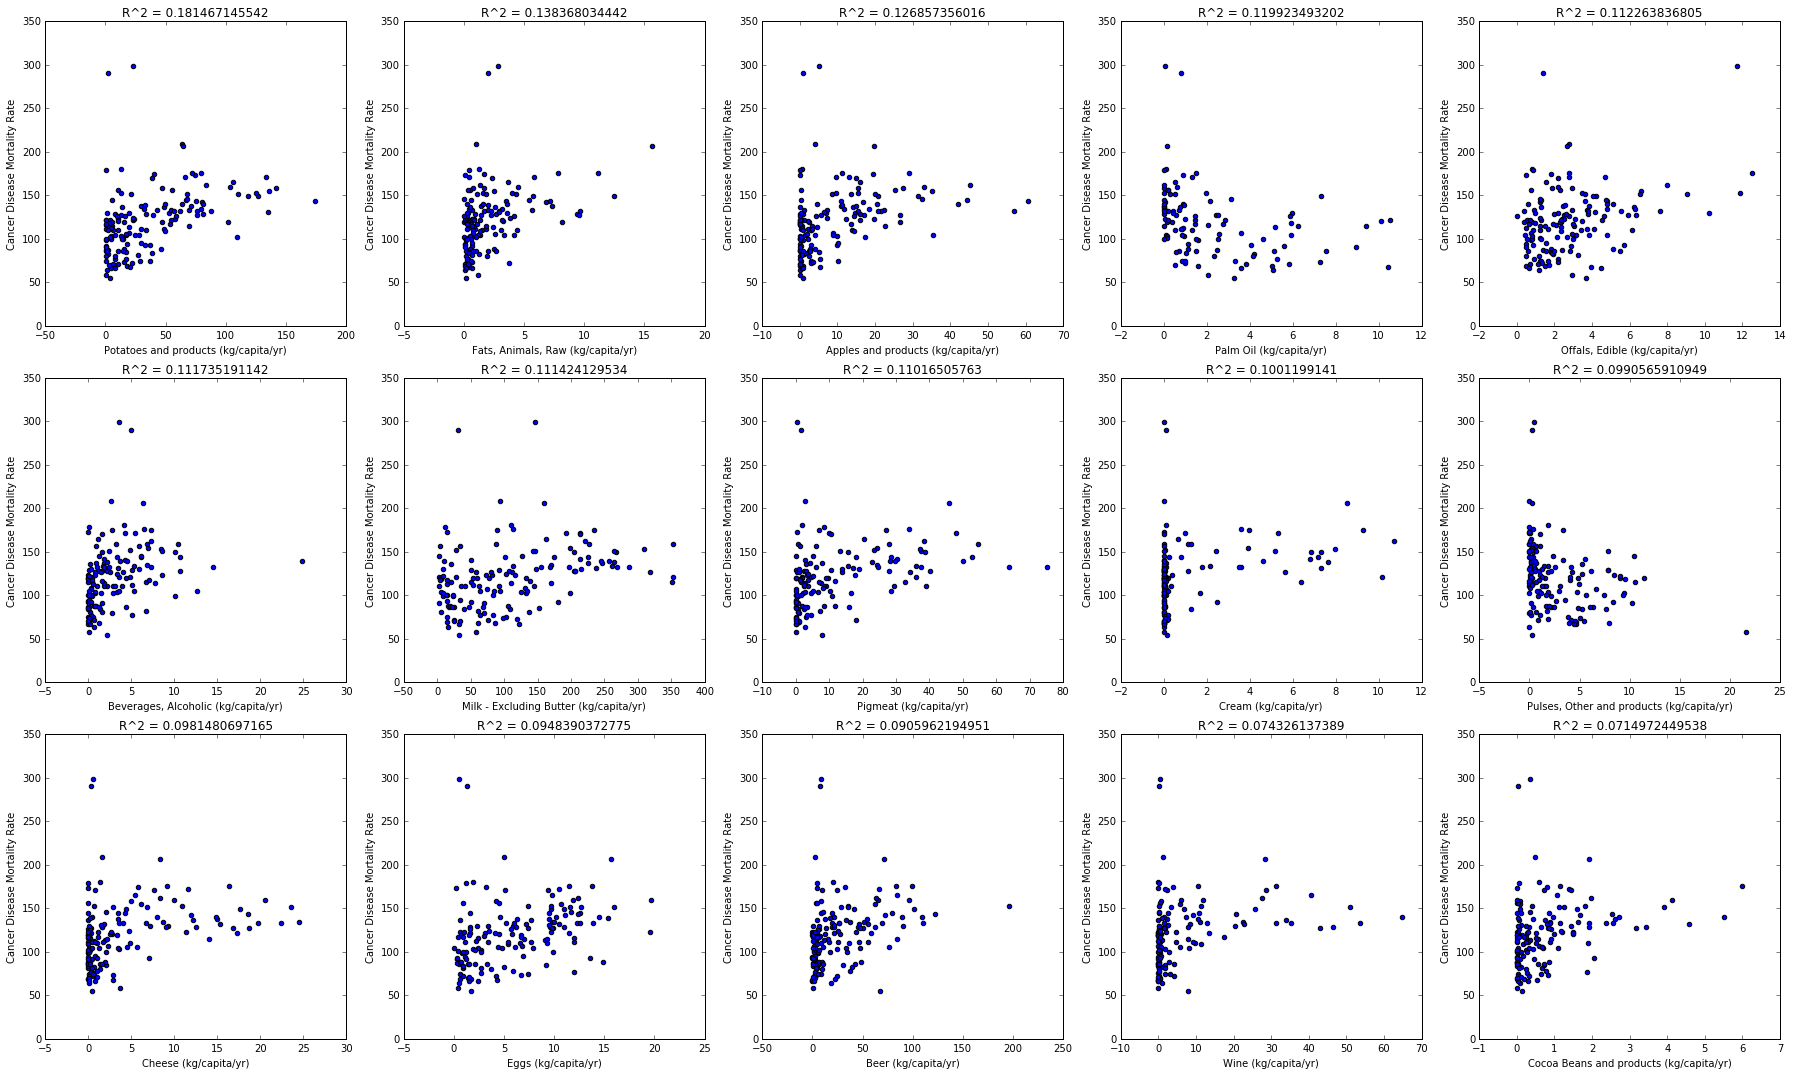

In [454]:
top_15(cancer_top15, "Cancer", cancer)

### Scatterplot of food predictors and diabetes mortality rates

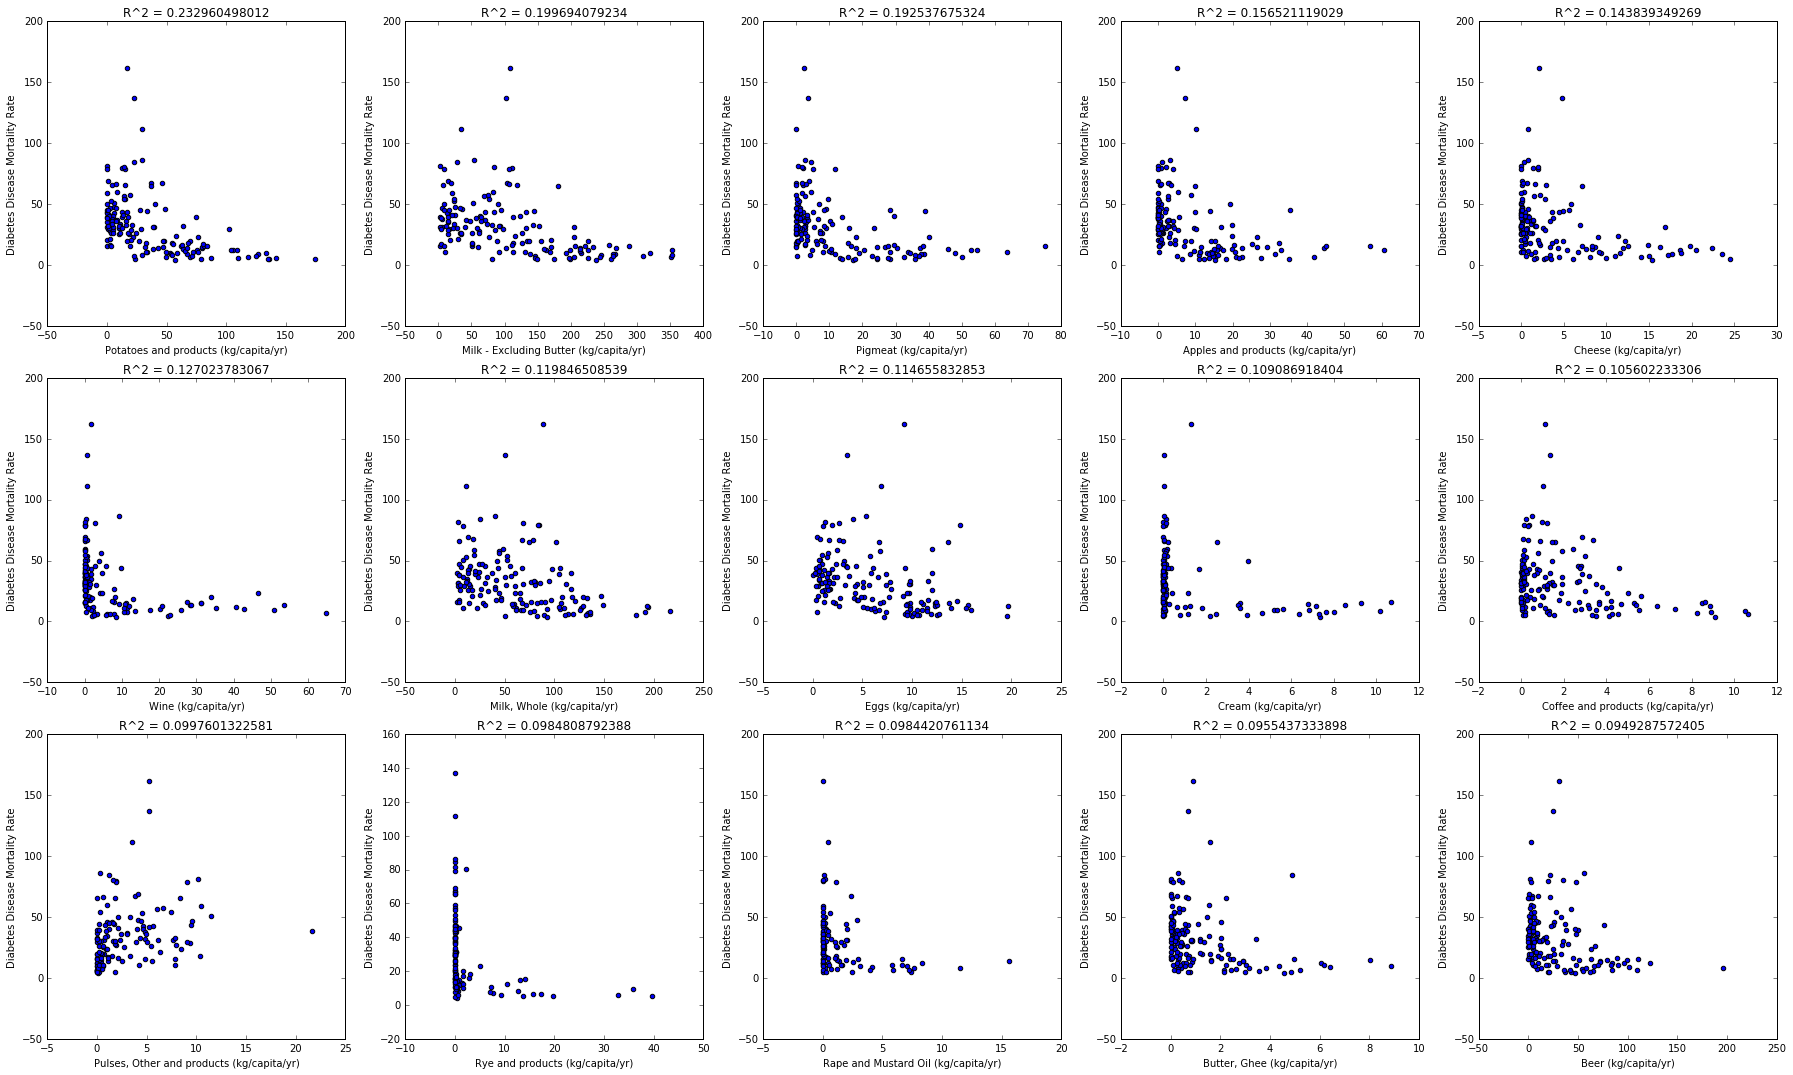

In [455]:
top_15(diabetes_top15, "Diabetes", diabetes)

### Scatterplot of food predictors and cardiovascular disease mortality rates

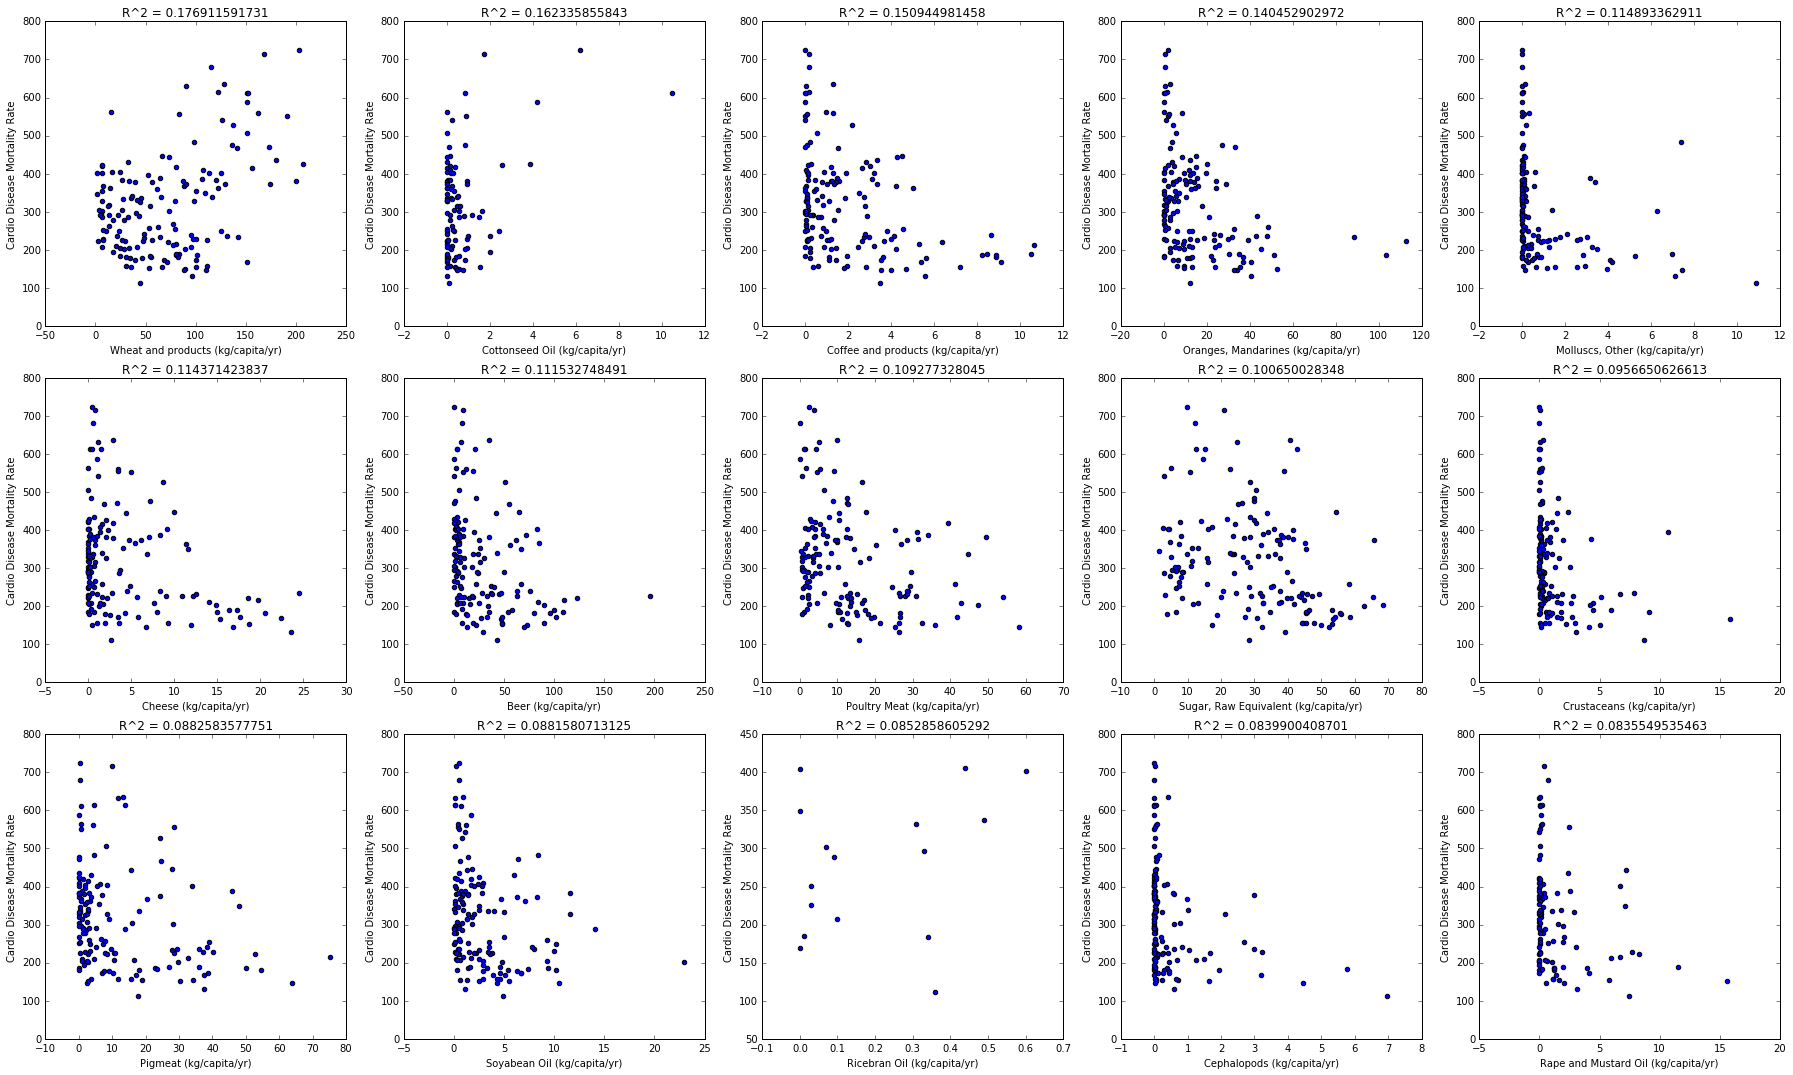

In [456]:
top_15(cardio_top15, "Cardio", cardio)

From the scatterplots presented of the top 15 predictors, it appears that our intuition is correct. Potatoes and products have a direct positive correlation for cancer and wheat and products have a postiive correlation with cardiovascular disease. Consumption of these products increases your risk while consumption of fruits and vegetables have an inverse relationship. Interestingly, potatoes and products have an inverse relationship with diabetes. This implies that the same predictors responds differently across diseases. Based on this research, we would want to calculate food predictor impact for the three diseases individually.

### Deeper Scatterplot Analysis

In a more thorough analysis using all 300 scatterplots, not displayed here for brevity, we identified the following noteworthy trends:

For diabetes, we saw a positive correlation between oil crops and mortality rates, pulses and mortality rates, and vegetal products and mortality rates. There is also a slight positive correlation between fruit consumption and diabetes, possibly relating to the high sugar content of fruit. Pulses (legumes, chickpeas, etc) and mortality rates were also positively correlated, which is unusual given to prior research and advice that pulses are an important part of a diabetic diet. We saw a negative correlation between treenuts and diabetes, which might offer some support to the value of unsaturated fats in diets. In most of these datasets, however, we did see some heteroscedasticity leading to relatively weak correlations.

For cardiovascular disease, we can see a positive correlation between cereals and mortality rates, which supports the “carb-cutting” and “low-carb” diets that are very common. There is also a positive correlation between starchy roots and cardiovascular disease, which makes sense given the previous trend with cereals. We also notice a negative correlation between fruit consumption and cardiovascular disease, and between pulse (legumes) consumption and cardiovascular disease. Both of these trends also make sense, as these both are foods groups on the healthier side. Molluscs and cephalopods also seem to be negatively correlated with cardiovascular disease mortality rates.

For cancer, there is a strong, positive correlation between alcohol consumption and cancer disease mortality. This agrees with our intuition as alcohol consumption hinders liver performance and slows bodily metabolism. Furthermore fruits, stimulants, and starchy roots also demonstrated a positive correlation. We hypothesize this can be attributed to the natural sugars in fruits, the adrenaline-releasing side effects of stimulants such as caffeine, and the high carbohydrate density of starchy roots. There was also a strong correlation between cancer and vegetal products but this relationship is not as intuitively clear and may be the result of an unexpected correlation rather than causation. Offals, molluscs, and cephalopods also seem to be positively correlated with cancer rates. For the remaining plots, we noticed no clear visual correlation between the instances of disease and food product consumption.